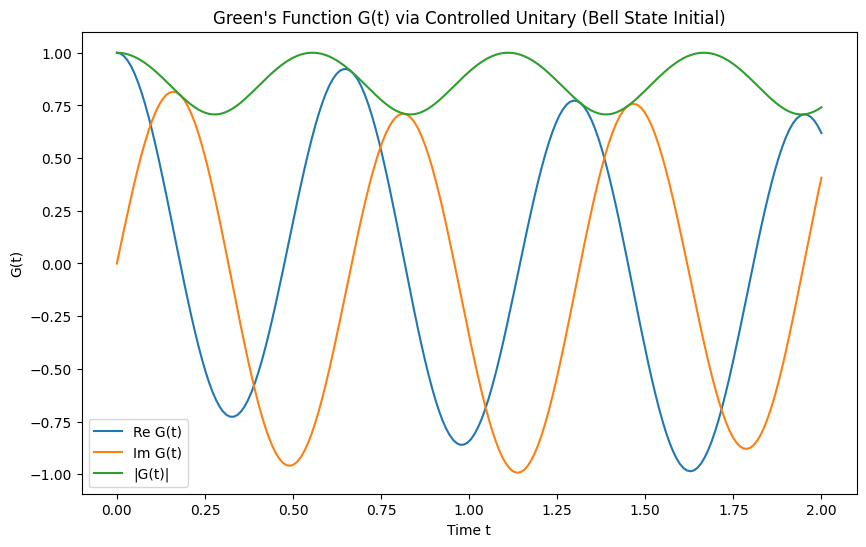

In [40]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Define basic 2x2 Pauli matrices.
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# Construct the 4x4 two-qubit Hamiltonian for the system.
# H_eff_sys = (-8)*I ⊗ Z + 4*(X ⊗ X + Y ⊗ Y)
I2 = I
H1 = -8 * np.kron(I2, Z)
H2 = 4 * (np.kron(X, X) + np.kron(Y, Y))
H_eff_sys = H1 + H2
# Note: Delta = sqrt((-8)^2 + 4*4^2) = sqrt(64+64) = 8√2, implicitly.

# Set up a device with 3 wires (qubits) in analytic mode.
dev = qml.device("default.qubit", wires=3, shots=None)
steps = 200  # Increase Trotter steps for better accuracy

# Function to prepare the system state (Bell state: (|01>+|10>)/√2) on wires 0 and 1.
def prepare_system_state():
    qml.PauliX(wires=1)      # |00> -> |01>
    qml.Hadamard(wires=0)    # |0> -> (|0>+|1>)/√2 on wire 0.
    qml.CNOT(wires=[0, 1])   # Transforms (|0,1>+|1,1>)/√2 to (|0,1>+|1,0>)/√2

# Build the controlled-unitary operator.
# We want to use U = exp(+I H_eff_sys (t/2)) so that for small t
# ⟨ψ|U|ψ⟩ ≈ 1 + i4t.
def controlled_unitary(t):
    U = expm(1j * H_eff_sys * (t/2))  # Notice the positive sign and factor (t/2)
    I_sys = np.eye(4)
    # Projection operators on ancilla:
    P0 = np.array([[1, 0], [0, 0]], dtype=complex)
    P1 = np.array([[0, 0], [0, 1]], dtype=complex)
    U_c = np.kron(I_sys, P0) + np.kron(U, P1)  # 8x8 matrix.
    return U_c

# QNode for the real part.
@qml.qnode(dev)
def circuit_real(t):
    prepare_system_state()            # Prepare system in (|01>+|10>)/√2.
    qml.Hadamard(wires=2)             # Prepare ancilla in |+>.
    U_c = controlled_unitary(t)
    qml.QubitUnitary(U_c, wires=[0, 1, 2])
    return qml.expval(qml.PauliX(wires=2))

# QNode for the imaginary part.
@qml.qnode(dev)
def circuit_imag(t):
    prepare_system_state()
    qml.Hadamard(wires=2)
    qml.PhaseShift(np.pi/2, wires=2)
    U_c = controlled_unitary(t)
    qml.QubitUnitary(U_c, wires=[0, 1, 2])
    return qml.expval(qml.PauliX(wires=2))

# Define the complex Green's function.
# We now include an extra phase factor to match the overall phase
# from the Mathematica theory. Specifically, we multiply by exp(i4t)
# so that for small t:
#   ⟨ψ|U|ψ⟩ ≈ 1 + i4t   and then G(t)= (1 + i4t)*exp(i4t) ≈ 1 + i8t.
def G(t):
    re = circuit_real(t)
    im = circuit_imag(t)
    return (re - 1j * im) * np.exp(1j * 4 * t)

# Compute G(t) over the time interval t in [0, 2].
t_vals = np.linspace(0, 2, 200)
G_vals = np.array([G(t) for t in t_vals])

# Plot the real part, imaginary part, and absolute value of G(t).
plt.figure(figsize=(10, 6))
plt.plot(t_vals, G_vals.real, label="Re G(t)")
plt.plot(t_vals, G_vals.imag, label="Im G(t)")
plt.plot(t_vals, np.abs(G_vals), label="|G(t)|")
plt.xlabel("Time t")
plt.ylabel("G(t)")
plt.title("Green's Function G(t) via Controlled Unitary (Bell State Initial)")
plt.legend()
plt.show()
